In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

# Collecting text

In [72]:
corpus = ['Tesla Inc (TSLA.O) on Wednesday surprised investors with a quarterly profit that sent its shares soaring, as Chief Executive Elon Musk promised a 2020 rollout of a cheaper SUV and more self-driving technology to stay ahead of larger rivals rushing into the premium electric vehicle market he created', 
'Shares rose nearly 21% to $307.12 after hours on the unexpected news, crossing $300 for the first time since March 1 after record deliveries and cost cuts ensured a profitable third quarter',
          'Tesla on Wednesday posted a cash balance increase to $5.3 billion and reported a profit of $1.86 per share, shattering analyst expectations for a loss of 42 cents per share']

# Removing stop words

In [73]:
def remove_stop_words(corpus):
    stop_words = ['Inc', 'TSLA.O', '$']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))    
    return results

corpus = remove_stop_words(corpus)

# Generating tokens

In [74]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)
        
words = set(words)
words

{'$1.86',
 '$300',
 '$307.12',
 '$5.3',
 '(TSLA.O)',
 '1',
 '2020',
 '21%',
 '42',
 'Chief',
 'Elon',
 'Executive',
 'March',
 'Musk',
 'SUV',
 'Shares',
 'Tesla',
 'Wednesday',
 'a',
 'after',
 'ahead',
 'analyst',
 'and',
 'as',
 'balance',
 'billion',
 'cash',
 'cents',
 'cheaper',
 'cost',
 'created',
 'crossing',
 'cuts',
 'deliveries',
 'electric',
 'ensured',
 'expectations',
 'first',
 'for',
 'he',
 'hours',
 'increase',
 'into',
 'investors',
 'its',
 'larger',
 'loss',
 'market',
 'more',
 'nearly',
 'news,',
 'of',
 'on',
 'per',
 'posted',
 'premium',
 'profit',
 'profitable',
 'promised',
 'quarter',
 'quarterly',
 'record',
 'reported',
 'rivals',
 'rollout',
 'rose',
 'rushing',
 'self-driving',
 'sent',
 'share',
 'share,',
 'shares',
 'shattering',
 'since',
 'soaring,',
 'stay',
 'surprised',
 'technology',
 'that',
 'the',
 'third',
 'time',
 'to',
 'unexpected',
 'vehicle',
 'with'}

# Generating labels for each word using skip gram

In [75]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
                
df = pd.DataFrame(data, columns = ['input', 'label'])

In [76]:
df.sample(10)

,input,label
24,with,quarterly
401,of,a
120,self-driving,to
329,increase,cash
102,cheaper,a
297,profitable,third
409,cents,of
350,reported,and
175,market,he
291,a,cuts


In [77]:
word2int

{'news,': 0,
 'with': 1,
 'posted': 2,
 'stay': 3,
 'nearly': 4,
 'per': 5,
 'cuts': 6,
 'time': 7,
 'a': 8,
 'Musk': 9,
 'Executive': 10,
 '21%': 11,
 'Elon': 12,
 'profit': 13,
 'created': 14,
 'third': 15,
 'self-driving': 16,
 'reported': 17,
 'SUV': 18,
 'rushing': 19,
 'cheaper': 20,
 'crossing': 21,
 'shattering': 22,
 'electric': 23,
 'billion': 24,
 'Tesla': 25,
 'sent': 26,
 'more': 27,
 'he': 28,
 'since': 29,
 'March': 30,
 'market': 31,
 'its': 32,
 'for': 33,
 'ahead': 34,
 'cost': 35,
 'cents': 36,
 'investors': 37,
 'larger': 38,
 'first': 39,
 'loss': 40,
 'into': 41,
 'to': 42,
 'record': 43,
 'Wednesday': 44,
 'on': 45,
 '2020': 46,
 'vehicle': 47,
 'share': 48,
 'soaring,': 49,
 'cash': 50,
 'profitable': 51,
 'after': 52,
 'quarter': 53,
 'expectations': 54,
 '$307.12': 55,
 'the': 56,
 'technology': 57,
 'rose': 58,
 '$1.86': 59,
 'rollout': 60,
 'ensured': 61,
 '42': 62,
 'deliveries': 63,
 '$5.3': 64,
 'share,': 65,
 'unexpected': 66,
 'Shares': 67,
 '$300': 68,

# Defining Tensorflow graph

In [78]:
# source: https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

# Train

In [79]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  5.170423
iteration 3000 loss is :  4.105168
iteration 6000 loss is :  3.7908256
iteration 9000 loss is :  3.5963485
iteration 12000 loss is :  3.4585135
iteration 15000 loss is :  3.3523965
iteration 18000 loss is :  3.2819028


# Words lookup table

In [80]:
vectors = sess.run(W1 + b1)
print(vectors)

[[-1.40231788e+00 -1.36373115e+00]
 [-1.76851049e-01  1.58270836e+00]
 [-2.46357226e+00  2.23314786e+00]
 [-5.79811335e-02  1.90604612e-01]
 [-1.06775260e+00 -1.80198312e+00]
 [ 2.27713776e+00  1.02633965e+00]
 [-9.85369086e-01  1.96403849e+00]
 [-1.61871266e+00 -7.72206128e-01]
 [ 2.20817730e-01  1.15038359e+00]
 [ 7.97862351e-01  5.10313749e-01]
 [ 2.27784324e+00 -1.25112200e+00]
 [-1.39420223e+00 -1.54812002e+00]
 [ 2.30446076e+00 -8.25061083e-01]
 [ 7.45074689e-01  1.51889539e+00]
 [ 3.90276194e-01 -1.38988924e+00]
 [ 1.67441934e-01  1.78781128e+00]
 [-1.49595499e+00  3.38012099e-01]
 [-1.78500220e-01  1.39183044e+00]
 [-1.01800501e+00  1.76942778e+00]
 [ 1.03711076e-01 -1.58328748e+00]
 [ 1.69834495e-03  1.81730688e+00]
 [-7.63274729e-01 -1.97705165e-01]
 [ 1.49350357e+00  1.18356168e+00]
 [-2.26338640e-01 -3.21928954e+00]
 [-1.30434501e+00  6.98536515e-01]
 [-3.33080721e+00  1.22216988e+00]
 [ 1.97265267e+00 -5.19865036e-01]
 [-7.22352445e-01  5.67783356e-01]
 [ 4.64148998e-01 -2

# Word vectors in table

In [81]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,"news,",-1.402318,-1.363731
1,with,-0.176851,1.582708
2,posted,-2.463572,2.233148
3,stay,-0.057981,0.190605
4,nearly,-1.067753,-1.801983
...,...,...,...
81,surprised,-1.468219,1.359248
82,promised,0.775543,1.144097
83,balance,-1.653111,1.355980
84,1,-1.991178,-0.485041


# Word vectors in a chart

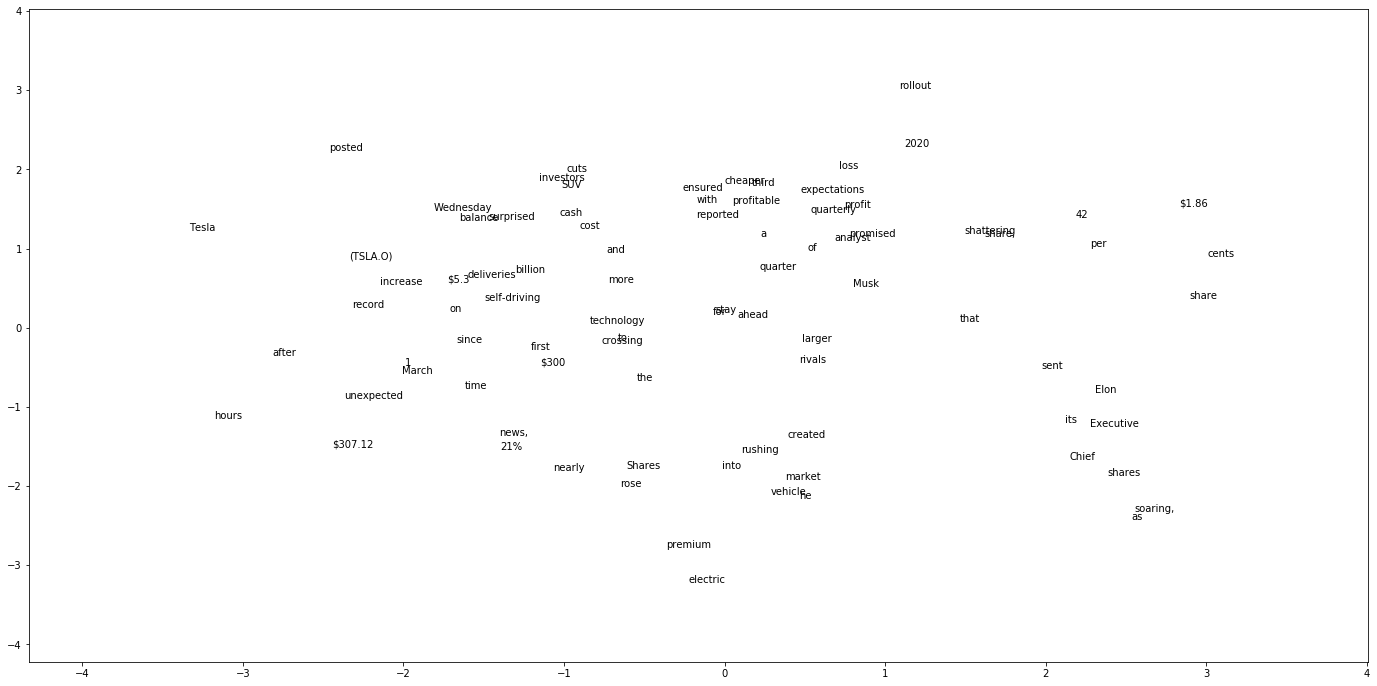

In [82]:
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (24, 12)

plt.show()